# Install Transformers Library

**Encoder (left):** The encoder receives an input and builds a representation of it (its features). This means that the model is optimized to acquire understanding from the input.

**Decoder (right):** The decoder uses the encoder’s representation (features) along with other inputs to generate a target sequence. This means that the model is optimized for generating outputs.

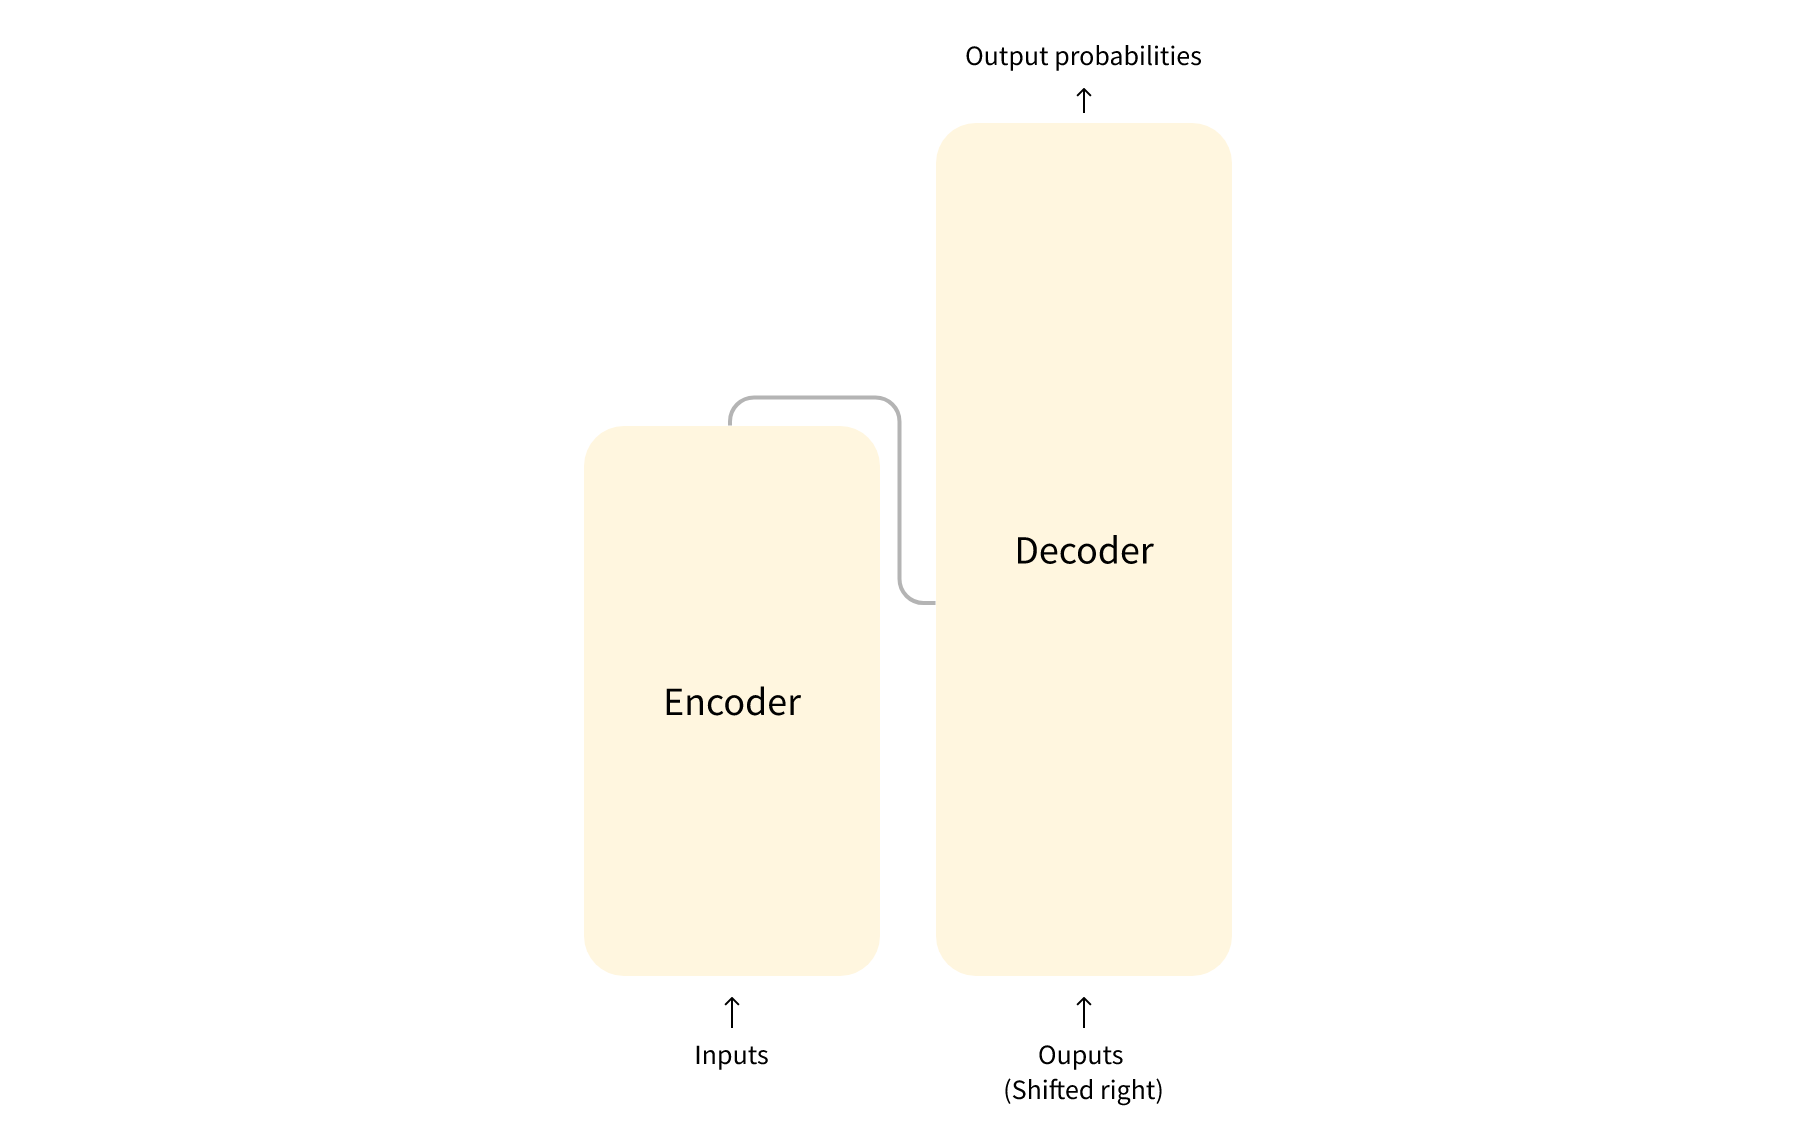

In [ ]:
!pip install transformers
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 36.0 MB/s 
     |████████████████████████████████| 6.6 MB 44.3 MB/s 
     |████████████████████████████████| 163 kB 65.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


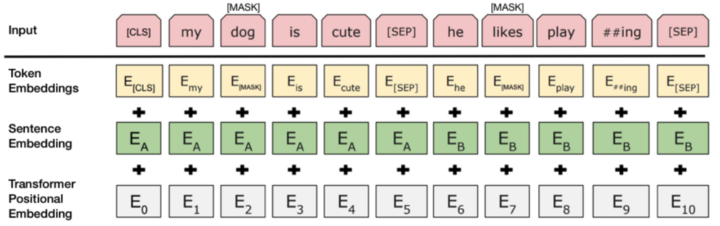

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import transformers
from transformers import AutoModel, BertTokenizerFast
import scikitplot as skplt #

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/KDM-ICP7/spam.csv", encoding = 'latin-1')
df = df[['v1', 'v2']]
df.columns = ['Label', 'text']
df.head()

,Label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df["Label"] = df["Label"].astype('category')
df["label"] = df["Label"].cat.codes
df.head()

,Label,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df.shape

(5572, 3)

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=5560, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=5560, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
test_text.shape

(836,)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["This ICP is about BERT", "We will use BERT for Spam Classification."]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 24582, 2361, 2003, 2055, 14324, 102, 0, 0, 0], [101, 2057, 2097, 2224, 14324, 2005, 12403, 2213, 5579, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
len(sent_id['input_ids'][1])

11

# Tokenization

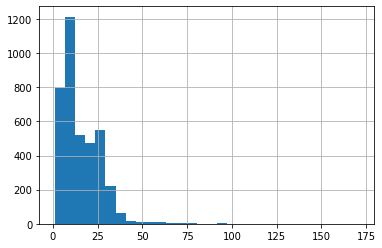

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

#Another way to describe bins, how many bars do you want in your histogram chart? A lot or a little?
pd.Series(seq_len).hist(bins = 30) 

In [ ]:
max_seq_len = 25
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
tokens_train['input_ids'][0]

[101,
 2115,
 2432,
 4070,
 2005,
 5718,
 20348,
 20348,
 20348,
 20348,
 2595,
 3065,
 6275,
 2575,
 4895,
 5596,
 21564,
 2098,
 2685,
 1012,
 2000,
 4366,
 2655,
 5511,
 102]

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask']) #This argument indicates to the model which tokens should be attended to, and which should not.
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
print(model)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
The optimizer used by the Trainer is AdamW, which is the same as Adam, but with a twist for weight decay regularization

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Find Class Weights

`compute_class_weight`: Estimate class weights for unbalanced datasets.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[0.57743559 3.72848948]


If you apply Pytorch’s `CrossEntropyLoss` to your output layer,
you get the same result as applying Pytorch’s `NLLLoss` to a
LogSoftmax layer added after your original output layer.

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
# weight: a manual rescaling weight given to each class. If given, it has to be a Tensor of size C. Otherwise, it is treated as if having all ones.
cross_entropy = nn.NLLLoss(weight=weights)  #

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
    
    # progress update after every 50 batches.
    # if step % 50 == 0 and not step == 0:
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # print(sent_id, mask)


    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
from babel.dates import format_date, format_datetime, format_time

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
    
    # Progress update every 50 batches.
    # if step % 50 == 0 and not step == 0:
      
    #   # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)
            
    #   # Report progress.
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')
save_path = '/content/drive/MyDrive/KDM-ICP7'
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in tqdm(range(epochs)):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '{}/best_saved_weights.pt'.format(save_path))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}, Validation Loss: {valid_loss:.3f}')

  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 1 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.559, Validation Loss: 0.323

 Epoch 2 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.373, Validation Loss: 0.218

 Epoch 3 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.293, Validation Loss: 0.171

 Epoch 4 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.247, Validation Loss: 0.216

 Epoch 5 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.230, Validation Loss: 0.176

 Epoch 6 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.244, Validation Loss: 0.786

 Epoch 7 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.217, Validation Loss: 0.155

 Epoch 8 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.188, Validation Loss: 0.144

 Epoch 9 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.189, Validation Loss: 0.173

 Epoch 10 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.191, Validation Loss: 0.405


# Load Saved Model

In [ ]:
#load weights of best model
save_path = '/content/drive/MyDrive/KDM-ICP7'
path = '{}/best_saved_weights.pt'.format(save_path)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds, np.exp(preds)

(array([[-3.8376454e-02, -3.2794387e+00],
        [-5.2877092e-03, -5.2450023e+00],
        [-2.6833878e+00, -7.0778005e-02],
        ...,
        [-3.5050407e-03, -5.6553111e+00],
        [-7.6395884e-04, -7.1774216e+00],
        [-2.0010386e-02, -3.9214897e+00]], dtype=float32),
 array([[9.6235067e-01, 3.7649382e-02],
        [9.9472624e-01, 5.2738097e-03],
        [6.8331271e-02, 9.3166870e-01],
        ...,
        [9.9650109e-01, 3.4988844e-03],
        [9.9923629e-01, 7.6363428e-04],
        [9.8018855e-01, 1.9811558e-02]], dtype=float32))

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       724
           1       0.88      0.91      0.89       112

    accuracy                           0.97       836
   macro avg       0.93      0.95      0.94       836
weighted avg       0.97      0.97      0.97       836




 [[710  14]
 [ 10 102]]


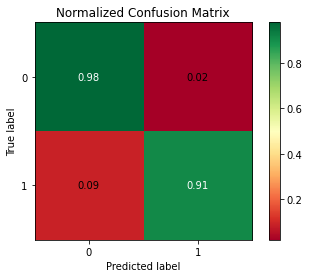

In [ ]:
confusion_matrix_BERT = confusion_matrix(test_y, preds)
print("\n", confusion_matrix_BERT)
skplt.metrics.plot_confusion_matrix(test_y, preds, normalize = True, cmap = 'RdYlGn' )

In [ ]:
k=0
for i in test_text:
  k=k+1
  print(k,i)

1 Alex says he's not ok with you not being ok with it
2 Oh my God. I'm almost home
3 Message Important information for O2 user. Today is your lucky day! 2 find out why log onto http://www.urawinner.com there is a fantastic surprise awaiting you
4 Kay... Since we are out already 
5 PISS IS TALKING IS SOMEONE THAT REALISE U THAT POINT THIS AT IS IT.(NOW READ IT BACKWARDS)
6 Sorry i missed your call. Can you please call back.
7 Dont you have message offer
8 Well I wasn't available as I washob nobbing with last night so they had to ask Nickey Platt instead of me!;
9 Good morning pookie pie! Lol hope I didn't wake u up
10 Free video camera phones with Half Price line rental for 12 mths and 500 cross ntwk mins 100 txts. Call MobileUpd8 08001950382 or Call2OptOut/674
11 If u laugh really loud.. If u talk spontaneously.. If u dont care what others feel.. U are probably with your dear &amp; best friends.. GOODEVENING Dear..:)
12 Spook up your mob with a Halloween collection of a logo & pic mess

In [ ]:
z=0
for j in preds:
  z=z+1
  print(z,j,"\n")

1 0 

2 0 

3 1 

4 0 

5 0 

6 0 

7 0 

8 0 

9 0 

10 1 

11 0 

12 1 

13 0 

14 0 

15 0 

16 0 

17 1 

18 0 

19 0 

20 0 

21 0 

22 0 

23 1 

24 0 

25 0 

26 0 

27 0 

28 1 

29 0 

30 0 

31 1 

32 0 

33 0 

34 0 

35 0 

36 0 

37 0 

38 0 

39 0 

40 0 

41 1 

42 0 

43 0 

44 0 

45 0 

46 0 

47 0 

48 0 

49 0 

50 0 

51 1 

52 0 

53 0 

54 0 

55 0 

56 0 

57 0 

58 1 

59 0 

60 0 

61 0 

62 0 

63 0 

64 0 

65 0 

66 0 

67 1 

68 1 

69 0 

70 0 

71 0 

72 0 

73 1 

74 0 

75 0 

76 1 

77 0 

78 0 

79 0 

80 0 

81 0 

82 0 

83 0 

84 0 

85 0 

86 0 

87 0 

88 0 

89 0 

90 0 

91 0 

92 0 

93 0 

94 0 

95 0 

96 0 

97 0 

98 0 

99 0 

100 0 

101 0 

102 0 

103 0 

104 0 

105 0 

106 0 

107 0 

108 0 

109 0 

110 0 

111 0 

112 0 

113 1 

114 0 

115 0 

116 0 

117 0 

118 0 

119 0 

120 0 

121 0 

122 0 

123 0 

124 1 

125 0 

126 1 

127 0 

128 0 

129 0 

130 0 

131 0 

132 0 

133 0 

134 0 

135 0 

136 0 

137 0 

138 0 

139 

# Assignment:
- Use another classifier from previous ICP and compare with BERT
- Import and compare another BERT-based pretrained model from Transformer (Source: https://huggingface.co/bert-base-uncased or https://huggingface.co/transformers/v3.3.1/pretrained_models.html)
- Change the architecture of the Finetuning model (Neurons, layers, ...)
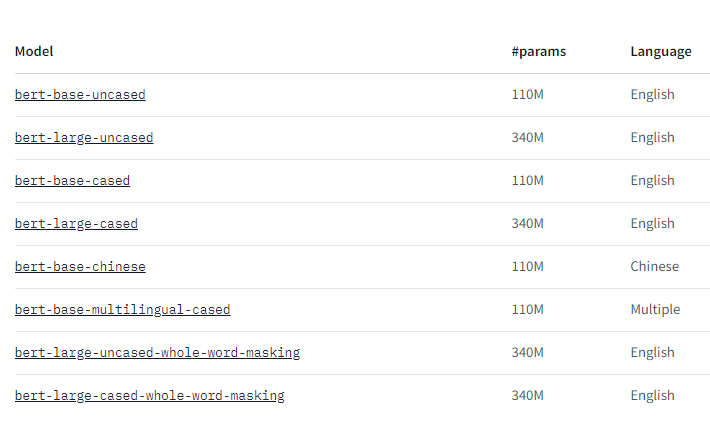

# Extracting n-Gram from the text data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
countvect = CountVectorizer(ngram_range = (2,2), )
x_counts = countvect.fit(train_text)

# preparing for training set
x_train_df = countvect.transform(train_text)

# preparing for test set
x_test_df = countvect.transform(test_text)

In [ ]:
vocab_size = len(countvect.vocabulary_)
vocab = countvect.vocabulary_
print(vocab)

{'your 2004': 31606, '2004 account': 470, 'account for': 1127, 'for 07xxxxxxxxx': 9153, '07xxxxxxxxx shows': 60, 'shows 786': 23300, '786 unredeemed': 848, 'unredeemed points': 28189, 'points to': 21049, 'to claim': 27074, 'claim call': 5744, 'call 08719181259': 4864, '08719181259 identifier': 160, 'identifier code': 12701, 'code xxxxx': 5899, 'xxxxx expires': 30922, 'expires 26': 8571, '26 03': 516, '03 05': 27, 'wat doing': 29199, 'doing there': 7547, 'ok then': 19324, 'then no': 26172, 'no need': 18269, 'need to': 17877, 'to tell': 27365, 'tell me': 25084, 'me anything': 16238, 'anything am': 2474, 'am going': 1762, 'going to': 10471, 'to sleep': 27338, 'sleep good': 23503, 'good night': 10572, 'wat time': 29215, 'time liao': 26836, 'liao where': 15067, 'where still': 29906, 'still got': 24415, 'hello darlin': 11810, 'darlin ive': 6714, 'ive finished': 14005, 'finished college': 8995, 'college now': 5938, 'now so': 18747, 'so txt': 23820, 'txt me': 27995, 'me when': 16435, 'when fin

# Data Model
## Algorithms used in this section are
* Naive Bayes Classifier
* Logestic Regression
* KNN
* SVC
* Deciosion Tree
* Random Forest


# Naive Bayes Classifier

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt 
import seaborn as sns 
import scikitplot as skplt #
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #



#import methods
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

The accuracy of Naive Bayes clasifier is 98.08612440191388%

 [[720   4]
 [ 12 100]]


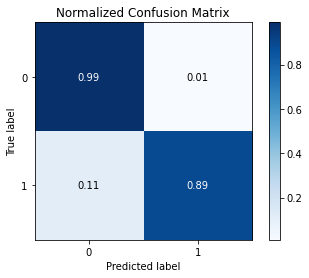

In [ ]:
clf = MultinomialNB()
clf.fit(x_train_df,train_labels)
predicted_values_NB = clf.predict(x_test_df)
predictions = dict()
accuracy = accuracy_score(test_labels, predicted_values_NB)
predictions['Naive Bayes'] = accuracy * 100
confusionmatrix = confusion_matrix(test_labels, predicted_values_NB)
print("The accuracy of Naive Bayes clasifier is {}%".format(accuracy * 100))
print("\n", confusionmatrix)
skplt.metrics.plot_confusion_matrix(test_labels, predicted_values_NB, normalize = True)
plt.show()

In [ ]:
print('Multinominal NB Report: \n', classification_report(test_labels, predicted_values_NB))

Multinominal NB Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.96      0.89      0.93       112

    accuracy                           0.98       836
   macro avg       0.97      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836



# Logistic Regression

The accuracy of Logistics Regression clasifier is 96.05263157894737%

 [[724   0]
 [ 33  79]]


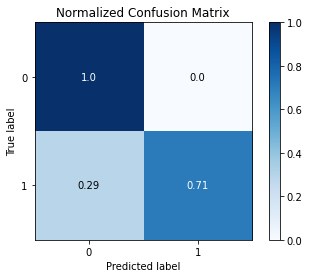

In [ ]:
clf = LogisticRegression()
clf.fit(x_train_df,train_labels)
predicted_values_LR = clf.predict(x_test_df)
accuracy = accuracy_score(test_labels, predicted_values_LR)
predictions['Logistic Regression'] = accuracy * 100
confusionmatrix = confusion_matrix(test_labels, predicted_values_LR)
print("The accuracy of Logistics Regression clasifier is {}%".format(accuracy * 100))
print("\n", confusionmatrix)
skplt.metrics.plot_confusion_matrix(test_labels, predicted_values_LR, normalize = True)
plt.show()

In [ ]:
print('Logistic Regression Report: \n', classification_report(test_labels, predicted_values_LR))

Logistic Regression Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       724
           1       1.00      0.71      0.83       112

    accuracy                           0.96       836
   macro avg       0.98      0.85      0.90       836
weighted avg       0.96      0.96      0.96       836



# KNN with GridSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
#param_grid = {'n_neighbors': [k_range],
             # 'weights' : ['uniform', 'distance'],
             # 'metric': ['euclidean','manhattan']}
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(x_train_df, train_labels)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
print(grid_search.best_params_)

{'n_neighbors': 1}


In [ ]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 93.10%


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(x_train_df, train_labels)

pred=knn.predict(x_test_df) 
print('KNN Report: \n', classification_report(test_labels, pred))

KNN Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       724
           1       1.00      0.62      0.76       112

    accuracy                           0.95       836
   macro avg       0.97      0.81      0.87       836
weighted avg       0.95      0.95      0.94       836



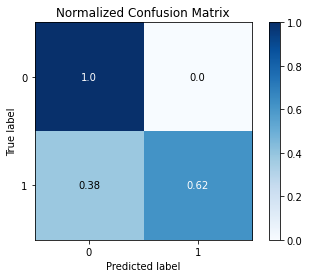

In [ ]:
skplt.metrics.plot_confusion_matrix(test_labels, pred, normalize = True)

# SVC with GridSearchCV

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(x_train_df, train_labels)

best_accuracy = grid.best_score_
best_parameters = grid.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.865 total time=   1.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.865 total time=   1.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.865 total time=   1.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.867 total time=   1.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.867 total time=   1.4s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.959 total time=   1.2s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.960 total time=   1.3s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.941 total time=   1.2s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.959 total time=   1.3s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.944 total time=   1.5s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.913 total time=   1.3s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

In [ ]:
svc = SVC(C= 100, gamma= 0.001, kernel= 'rbf')

svc.fit(x_train_df, train_labels)

pred=svc.predict(x_test_df) 

print('SVC Report: \n', classification_report(test_labels, pred))

SVC Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       724
           1       1.00      0.72      0.84       112

    accuracy                           0.96       836
   macro avg       0.98      0.86      0.91       836
weighted avg       0.96      0.96      0.96       836



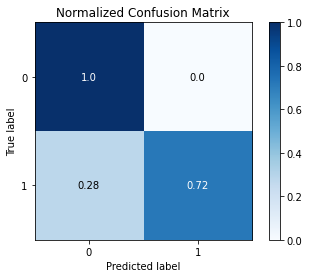

In [ ]:
skplt.metrics.plot_confusion_matrix(test_labels, pred, normalize = True)

# Decision Tree with GridSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(x_train_df, train_labels)
best_accuracy = grid_search_cv.best_score_
best_parameters = grid_search_cv.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 3 folds for each of 294 candidates, totalling 882 fits
Best Accuracy: 95.33 %
Best Parameters: {'max_leaf_nodes': 89, 'min_samples_split': 4}


In [ ]:
dt = DecisionTreeClassifier(max_leaf_nodes= 89, min_samples_split= 4)

dt.fit(x_train_df, train_labels)

pred=dt.predict(x_test_df) 

print('Decision Tree Report: \n', classification_report(test_labels, pred))

Decision Tree Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       724
           1       0.93      0.77      0.84       112

    accuracy                           0.96       836
   macro avg       0.95      0.88      0.91       836
weighted avg       0.96      0.96      0.96       836



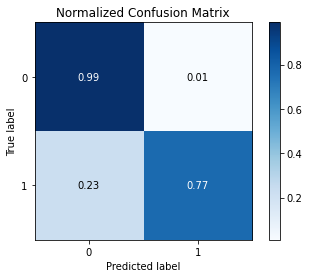

In [ ]:
skplt.metrics.plot_confusion_matrix(test_labels, pred, normalize = True)

# Random Forest with GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = [{'n_estimators':[10,20,30,40,50,60,70],
               'max_depth': [3,4,5,7],
               'criterion':['entropy'],
               'min_samples_split':[5,4,6,7,8],
               'max_features':['auto', 'sqrt', 'log2']
               }]
grid_search = GridSearchCV(estimator= RandomForestClassifier(n_estimators=20),
                           param_grid= parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           verbose=3,
                           cv = 10)

grid_search.fit(x_train_df, train_labels)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
Best Accuracy: 86.90 %
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 10}


In [ ]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=7, max_features= 'sqrt', min_samples_split= 5, n_estimators= 10)

rfc.fit(x_train_df, train_labels)

pred=rfc.predict(x_test_df) 

print('Random Forest Report: \n', classification_report(test_labels, pred))

Random Forest Report: 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       724
           1       1.00      0.02      0.04       112

    accuracy                           0.87       836
   macro avg       0.93      0.51      0.48       836
weighted avg       0.89      0.87      0.81       836



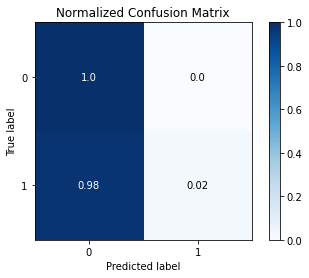

In [ ]:
skplt.metrics.plot_confusion_matrix(test_labels, pred, normalize = True)

# Another Pretrained BERT Model

## Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-cased', return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["This ICP is about BERT", "We will use BERT-large-cased for Spam Classification."]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 1188, 146, 13113, 1110, 1164, 139, 9637, 1942, 102, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1284, 1209, 1329, 139, 9637, 1942, 118, 1415, 118, 1692, 1181, 1111, 23665, 1306, 19295, 119, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
len(sent_id['input_ids'][1])

18

# Tokenization with new BERT

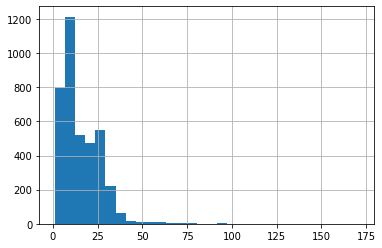

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

#Another way to describe bins, how many bars do you want in your histogram chart? A lot or a little?
pd.Series(seq_len).hist(bins = 30) 

In [ ]:
max_seq_len = 25
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
tokens_train['input_ids'][0]

[101,
 2353,
 1516,
 3300,
 1111,
 5004,
 3190,
 3190,
 3190,
 3190,
 3190,
 3190,
 3190,
 3190,
 3190,
 2196,
 5603,
 1545,
 8362,
 4359,
 3051,
 4611,
 1827,
 119,
 102]

# Convert Integers Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask']) #This argument indicates to the model which tokens should be attended to, and which should not.
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create a Dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
print(model)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[0.57743559 3.72848948]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
# weight: a manual rescaling weight given to each class. If given, it has to be a Tensor of size C. Otherwise, it is treated as if having all ones.
cross_entropy = nn.NLLLoss(weight=weights)  #

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
from tqdm.notebook import tqdm

# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
    
    # progress update after every 50 batches.
    # if step % 50 == 0 and not step == 0:
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad() 

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # print(sent_id, mask)


    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [ ]:
from babel.dates import format_date, format_datetime, format_time

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
    
    # Progress update every 50 batches.
    # if step % 50 == 0 and not step == 0:
      
    #   # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)
            
    #   # Report progress.
    #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')
save_path = '/content/drive/MyDrive/KDM-ICP7'
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in tqdm(range(epochs)):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '{}/best_saved_weights.pt'.format(save_path))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}, Validation Loss: {valid_loss:.3f}')

  0%|          | 0/10 [00:00<?, ?it/s]


 Epoch 1 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.372, Validation Loss: 0.253

 Epoch 2 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.407, Validation Loss: 0.218

 Epoch 3 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.384, Validation Loss: 0.244

 Epoch 4 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.313, Validation Loss: 0.241

 Epoch 5 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.277, Validation Loss: 0.212

 Epoch 6 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.294, Validation Loss: 0.361

 Epoch 7 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.290, Validation Loss: 0.165

 Epoch 8 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.284, Validation Loss: 0.203

 Epoch 9 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.259, Validation Loss: 0.163

 Epoch 10 / 10


  0%|          | 0/122 [00:00<?, ?it/s]


Evaluating...


  0%|          | 0/27 [00:00<?, ?it/s]


Training Loss: 0.256, Validation Loss: 0.191


# Load Saved Model

In [ ]:
#load weights of best model
save_path = '/content/drive/MyDrive/KDM-ICP7'
path = '{}/best_saved_weights.pt'.format(save_path)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Prediction for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds, np.exp(preds)

(array([[-9.6291127e-03, -4.6477690e+00],
        [-6.4731683e-03, -5.0433307e+00],
        [-5.0190649e+00, -6.6326945e-03],
        ...,
        [-3.2744384e-03, -5.7232485e+00],
        [-3.5625309e-04, -7.9399066e+00],
        [-1.4538661e-02, -4.2382021e+00]], dtype=float32),
 array([[9.9041712e-01, 9.5829573e-03],
        [9.9354768e-01, 6.4522224e-03],
        [6.6107055e-03, 9.9338925e-01],
        ...,
        [9.9673086e-01, 3.2690738e-03],
        [9.9964380e-01, 3.5623976e-04],
        [9.8556650e-01, 1.4433519e-02]], dtype=float32))

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       724
           1       0.78      0.89      0.83       112

    accuracy                           0.95       836
   macro avg       0.88      0.93      0.90       836
weighted avg       0.96      0.95      0.95       836




 [[695  29]
 [ 12 100]]


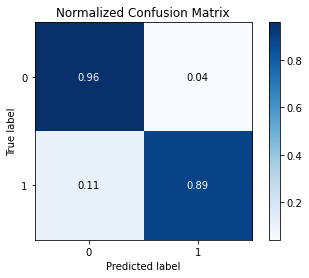

In [ ]:
confusion_matrix_BERT = confusion_matrix(test_y, preds)
print("\n", confusion_matrix_BERT)
skplt.metrics.plot_confusion_matrix(test_y, preds, normalize = True )

In [ ]:
k=0
for i in test_text:
  k=k+1
  print(k,i)

1 Alex says he's not ok with you not being ok with it
2 Oh my God. I'm almost home
3 Message Important information for O2 user. Today is your lucky day! 2 find out why log onto http://www.urawinner.com there is a fantastic surprise awaiting you
4 Kay... Since we are out already 
5 PISS IS TALKING IS SOMEONE THAT REALISE U THAT POINT THIS AT IS IT.(NOW READ IT BACKWARDS)
6 Sorry i missed your call. Can you please call back.
7 Dont you have message offer
8 Well I wasn't available as I washob nobbing with last night so they had to ask Nickey Platt instead of me!;
9 Good morning pookie pie! Lol hope I didn't wake u up
10 Free video camera phones with Half Price line rental for 12 mths and 500 cross ntwk mins 100 txts. Call MobileUpd8 08001950382 or Call2OptOut/674
11 If u laugh really loud.. If u talk spontaneously.. If u dont care what others feel.. U are probably with your dear &amp; best friends.. GOODEVENING Dear..:)
12 Spook up your mob with a Halloween collection of a logo & pic mess

In [ ]:
z=0
for j in preds:
  z=z+1
  print(z,j,"\n")

1 0 

2 0 

3 1 

4 0 

5 0 

6 0 

7 0 

8 0 

9 0 

10 1 

11 0 

12 1 

13 0 

14 0 

15 0 

16 0 

17 1 

18 0 

19 0 

20 0 

21 0 

22 0 

23 1 

24 0 

25 0 

26 0 

27 0 

28 0 

29 0 

30 0 

31 0 

32 0 

33 0 

34 0 

35 0 

36 0 

37 0 

38 0 

39 0 

40 0 

41 1 

42 0 

43 0 

44 0 

45 0 

46 0 

47 0 

48 0 

49 0 

50 0 

51 1 

52 0 

53 0 

54 0 

55 0 

56 0 

57 0 

58 1 

59 0 

60 0 

61 0 

62 0 

63 0 

64 0 

65 0 

66 0 

67 1 

68 1 

69 0 

70 0 

71 0 

72 0 

73 1 

74 0 

75 0 

76 1 

77 1 

78 0 

79 1 

80 0 

81 0 

82 0 

83 0 

84 0 

85 0 

86 1 

87 0 

88 0 

89 0 

90 0 

91 0 

92 0 

93 0 

94 0 

95 0 

96 0 

97 0 

98 0 

99 0 

100 0 

101 0 

102 0 

103 0 

104 0 

105 0 

106 0 

107 0 

108 0 

109 0 

110 0 

111 0 

112 0 

113 1 

114 0 

115 0 

116 0 

117 0 

118 0 

119 0 

120 0 

121 0 

122 0 

123 0 

124 1 

125 0 

126 1 

127 0 

128 0 

129 0 

130 0 

131 0 

132 0 

133 0 

134 0 

135 0 

136 0 

137 0 

138 0 

139 

# Accuracy Comparison of Several ML Models

In [ ]:
# Import pandas library
import pandas as pd
  
# initialize list elements
data = [['Naive Bayes',98], ['Logistic Regression',96 ],['KNN',95],['Random Forest',87],['Decision Tree',96],['SVC',96],['BERT-base-uncased', 97],['BERT-base-cased',95]]
Algorithms = ['Naive Bayes', 'Logistic Regression', 'KNN', 'Random Forest', 'Decision Tree', 'SVC']
Accuracy_percentage = [97.93, 95.33, 94.84, 89.9, 96.81, 98.83]
  
# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(data , columns=['Algorithms', 'Accuracy Percentage'])
  
# print dataframe.
df

,Algorithms,Accuracy Percentage
0,Naive Bayes,98
1,Logistic Regression,96
2,KNN,95
3,Random Forest,87
4,Decision Tree,96
5,SVC,96
6,BERT-base-uncased,97
7,BERT-base-cased,95


# Visualization

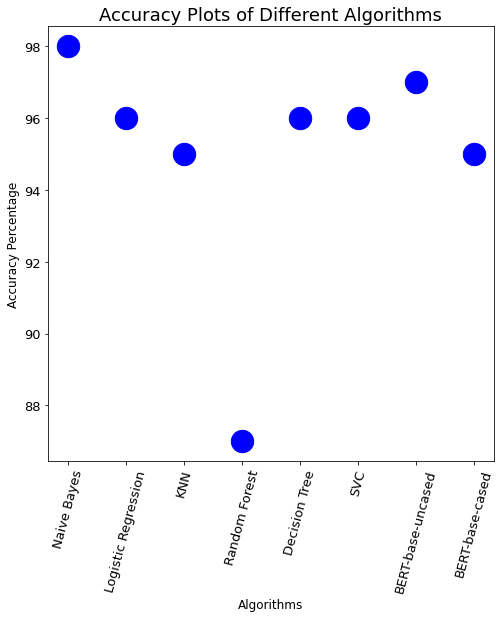

In [ ]:
#Get current axis
import matplotlib.pyplot as plt

ax = plt.gca()
#plt.figure(figsize=(15,15))
df.plot(kind = 'scatter',x = 'Algorithms',
        y = 'Accuracy Percentage',s = 500,
        color = 'blue',ax = ax, fontsize=13,
        figsize=(8,8))
plt.xlabel('Algorithms', fontsize=12)
plt.ylabel('Accuracy Percentage', fontsize=12)
  
# set the title
plt.title('Accuracy Plots of Different Algorithms',fontsize=18)
plt.xticks(rotation=75)  
 
# show the plot
plt.show()